In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import precision_score,f1_score, accuracy_score, classification_report,confusion_matrix,classification_report
import pickle
from sklearn.linear_model import LogisticRegression
# importing sys
import sys
# adding helper_func to the system path
sys.path.insert(0, '../helper_functions/')
# importing actual functions
from helper_functions import preds_N_cm,plot_xgb_importance

In [2]:
building = pd.read_csv("../../Data/Complete_N_Cleaned.csv")
building.head()

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,120101000011,12,1207,120703,1,1,9,288,9,9,...,0,0,0,0,0,0,0,0,0,0
1,120101000021,12,1207,120703,1,1,15,364,9,9,...,0,0,0,0,0,0,0,0,0,0
2,120101000031,12,1207,120703,1,1,20,384,9,9,...,0,0,0,0,0,0,0,0,0,0
3,120101000041,12,1207,120703,1,1,20,312,9,9,...,0,0,0,0,0,0,0,0,0,0
4,120101000051,12,1207,120703,1,1,30,308,9,9,...,0,0,0,0,0,0,0,0,0,0


In [3]:
print('confirming no nulls: ',building.isnull().sum().sum())
building.dtypes

confirming no nulls:  0


building_id                                 int64
district_id                                 int64
vdcmun_id                                   int64
ward_id                                     int64
count_floors_pre_eq                         int64
count_floors_post_eq                        int64
age_building                                int64
plinth_area_sq_ft                           int64
height_ft_pre_eq                            int64
height_ft_post_eq                           int64
land_surface_condition                     object
foundation_type                            object
roof_type                                  object
ground_floor_type                          object
other_floor_type                           object
position                                   object
plan_configuration                         object
has_superstructure_adobe_mud                int64
has_superstructure_mud_mortar_stone         int64
has_superstructure_stone_flag               int64


In [4]:
# prepping original data to dummify
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical = ['object']
numdf = building.copy().select_dtypes(include=numerics)
catdf = building.copy().select_dtypes(include=categorical)
#catdf
catdf.head()

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,technical_solution_proposed,legal_ownership_status
0,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_used_in_risk,major_repair,private
1,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_repaired_and_used,reconstruction,private
2,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_repaired_and_used,minor_repair,private
3,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_repaired_and_used,minor_repair,private
4,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_repaired_and_used,minor_repair,private


In [5]:
# will dummify these to pass into models
dummified_1 = pd.get_dummies(data=catdf,drop_first=True) 
dummified_1 = pd.concat([numdf,dummified_1],axis=1)
print(dummified_1.shape)
dummified_1.head()

(762106, 72)


,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,condition_post_eq_damaged_rubble_clear_new_building_built,condition_post_eq_damaged_rubble_unclear,condition_post_eq_damaged_used_in_risk,condition_post_eq_not_damaged,technical_solution_proposed_minor_repair,technical_solution_proposed_no_need,technical_solution_proposed_reconstruction,legal_ownership_status_other,legal_ownership_status_private,legal_ownership_status_public
0,120101000011,12,1207,120703,1,1,9,288,9,9,...,0,0,1,0,0,0,0,0,1,0
1,120101000021,12,1207,120703,1,1,15,364,9,9,...,0,0,0,0,0,0,1,0,1,0
2,120101000031,12,1207,120703,1,1,20,384,9,9,...,0,0,0,0,1,0,0,0,1,0
3,120101000041,12,1207,120703,1,1,20,312,9,9,...,0,0,0,0,1,0,0,0,1,0
4,120101000051,12,1207,120703,1,1,30,308,9,9,...,0,0,0,0,1,0,0,0,1,0


In [6]:
# prepping my training and testing batches double checking class balances
X = dummified_1.drop(columns = ['building_id','damage_grade']) 
y = dummified_1['damage_grade']-1
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=42)
print(y_test.unique())
y_test.value_counts(normalize=True) # double checking that it was stratified 

[3 0 4 1 2]


4    0.361865
3    0.241231
2    0.178993
1    0.114493
0    0.103418
Name: damage_grade, dtype: float64

In [7]:
# standardize data
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)


#### Important Note: I had to alter my class from 1-5 to 0-4 for the classifier below.
The baseline is 36%, since we have some pretty imbalanced classes thus our class 4 (grade 5).

In [20]:
%%time 
# instantiating first model (most of these are defaults)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=8_000,random_state=42)

model.fit(Xs_train, y_train)

CPU times: user 12min 14s, sys: 58.4 s, total: 13min 12s
Wall time: 7min 50s


LogisticRegression(max_iter=8000, multi_class='multinomial')

Accuracy: 87.98%

(micro) precision score:  0.8798385530659697         (macro) precision score:  0.8707168394883785
(micro) f1 score:  0.8798385530659697                (macro) f1 score:  0.8636704158162303

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.99      0.87      0.92     19704
           1       0.79      0.84      0.82     21814
           2       0.78      0.74      0.76     34103
           3       0.79      0.91      0.85     45961
           4       1.00      0.95      0.97     68945

    accuracy                           0.88    190527
   macro avg       0.87      0.86      0.86    190527
weighted avg       0.89      0.88      0.88    190527



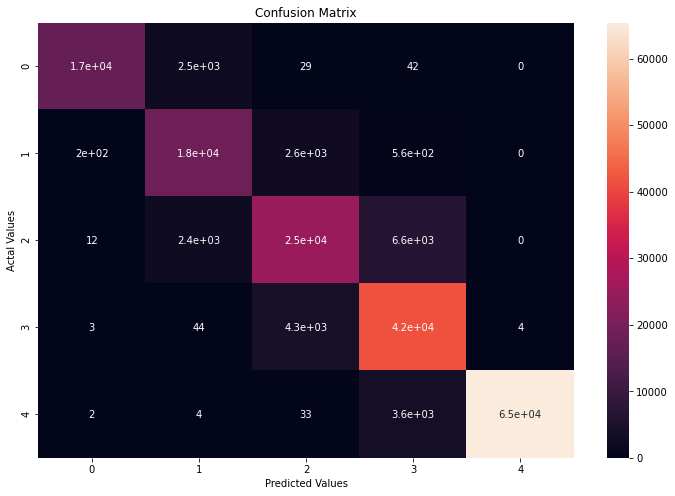

In [24]:
preds_N_cm(model,Xs_train,y_train,Xs_test,y_test)   

In [7]:
# A REALIZATION need to drop anything related to the post earthquake information to model future damage
catdf[['condition_post_eq','condition_post_eq']].head(2)

pre_eq_cat = catdf.drop(columns=['condition_post_eq','condition_post_eq'])
pre_eq_cat.head(2)

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,technical_solution_proposed,legal_ownership_status
0,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,major_repair,private
1,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,reconstruction,private


In [8]:
dummified_1 = pd.get_dummies(data=pre_eq_cat,drop_first=True) 
dummified_1 = pd.concat([numdf,dummified_1],axis=1)
print(dummified_1.shape)
dummified_1[['count_floors_post_eq' , 'height_ft_post_eq']].head(2)

(762106, 65)


,count_floors_post_eq,height_ft_post_eq
0,1,9
1,1,9


In [9]:
dummified_1.drop(columns=['count_floors_post_eq' , 'height_ft_post_eq','technical_solution_proposed'],inplace=True)
dummified_1.head()

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,plan_configuration_rectangular,plan_configuration_square,plan_configuration_t_shape,plan_configuration_u_shape,technical_solution_proposed_minor_repair,technical_solution_proposed_no_need,technical_solution_proposed_reconstruction,legal_ownership_status_other,legal_ownership_status_private,legal_ownership_status_public
0,120101000011,12,1207,120703,1,9,288,9,0,1,...,1,0,0,0,0,0,0,0,1,0
1,120101000021,12,1207,120703,1,15,364,9,0,1,...,1,0,0,0,0,0,1,0,1,0
2,120101000031,12,1207,120703,1,20,384,9,0,1,...,1,0,0,0,1,0,0,0,1,0
3,120101000041,12,1207,120703,1,20,312,9,0,1,...,1,0,0,0,1,0,0,0,1,0
4,120101000051,12,1207,120703,1,30,308,9,0,1,...,1,0,0,0,1,0,0,0,1,0


In [10]:
# prepping my training and testing batches double checking class balances
X = dummified_1.drop(columns = ['building_id','damage_grade']) 
y = dummified_1['damage_grade']-1
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=42)
print(y_test.unique())
y_test.value_counts(normalize=True) # double checking that it was stratified 

[3 0 4 1 2]


4    0.361865
3    0.241231
2    0.178993
1    0.114493
0    0.103418
Name: damage_grade, dtype: float64

In [11]:
# standardize data
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)

In [12]:
%%time  
# instantiating first model (most of these are defaults)
model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=8_000,random_state=42)

model.fit(Xs_train, y_train)

CPU times: user 8min 55s, sys: 23.2 s, total: 9min 18s
Wall time: 5min 49s
CPU times: user 8min 55s, sys: 23.2 s, total: 9min 18s
Wall time: 5min 49s


LogisticRegression(max_iter=8000, multi_class='multinomial', random_state=42)

Accuracy: 66.55%

(micro) precision score:  0.6655329690804977         (macro) precision score:  0.7062073490260184
(micro) f1 score:  0.6655329690804977                (macro) f1 score:  0.6453831618205659

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.95      0.68      0.79     19704
           1       0.68      0.83      0.74     21814
           2       0.78      0.74      0.76     34103
           3       0.51      0.12      0.20     45961
           4       0.61      0.94      0.74     68945

    accuracy                           0.67    190527
   macro avg       0.71      0.66      0.65    190527
weighted avg       0.66      0.67      0.62    190527



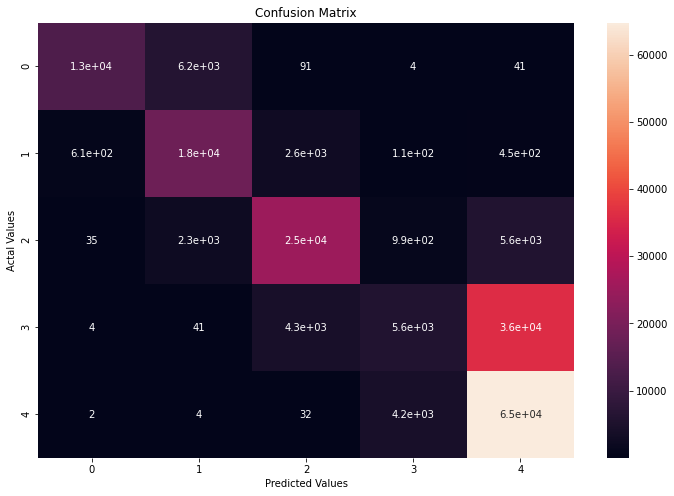

In [13]:
preds_N_cm(model,Xs_train,y_train,Xs_test,y_test)

Accuracy: 66.56%

(micro) precision score:  0.6655802064799214         (macro) precision score:  0.7066513534959078
(micro) f1 score:  0.6655802064799214                (macro) f1 score:  0.6453421701697908

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.95      0.68      0.79     19704
           1       0.68      0.83      0.74     21814
           2       0.78      0.74      0.76     34103
           3       0.52      0.12      0.20     45961
           4       0.61      0.94      0.74     68945

    accuracy                           0.67    190527
   macro avg       0.71      0.66      0.65    190527
weighted avg       0.66      0.67      0.62    190527



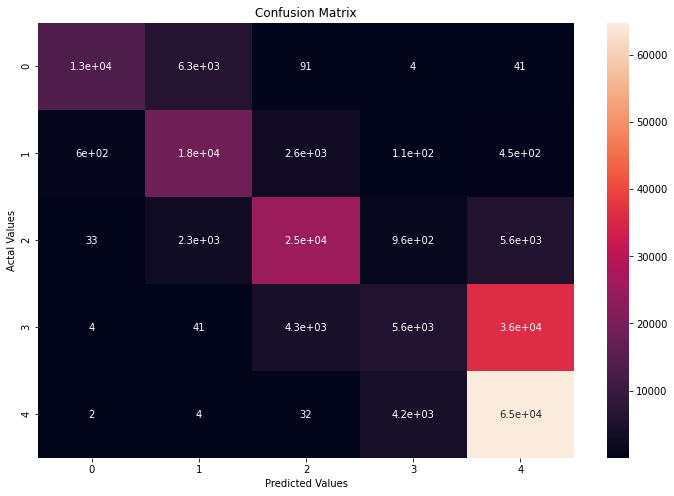

CPU times: user 7min 1s, sys: 18.9 s, total: 7min 20s
Wall time: 4min 47s


In [14]:
%%time  
# instantiating first model (most of these are defaults) ALTERING parameter in LogReg C, default=1.0
model = LogisticRegression(multi_class='multinomial',C=0.5, solver='lbfgs',max_iter=8_000,random_state=42)

model.fit(Xs_train, y_train)
preds_N_cm(model,Xs_train,y_train,Xs_test,y_test)

Accuracy: 66.56%

(micro) precision score:  0.6656116980795372         (macro) precision score:  0.7068193916361926
(micro) f1 score:  0.6656116980795372                (macro) f1 score:  0.6452435067423061

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.95      0.68      0.79     19704
           1       0.68      0.83      0.74     21814
           2       0.78      0.74      0.76     34103
           3       0.52      0.12      0.20     45961
           4       0.61      0.94      0.74     68945

    accuracy                           0.67    190527
   macro avg       0.71      0.66      0.65    190527
weighted avg       0.66      0.67      0.62    190527



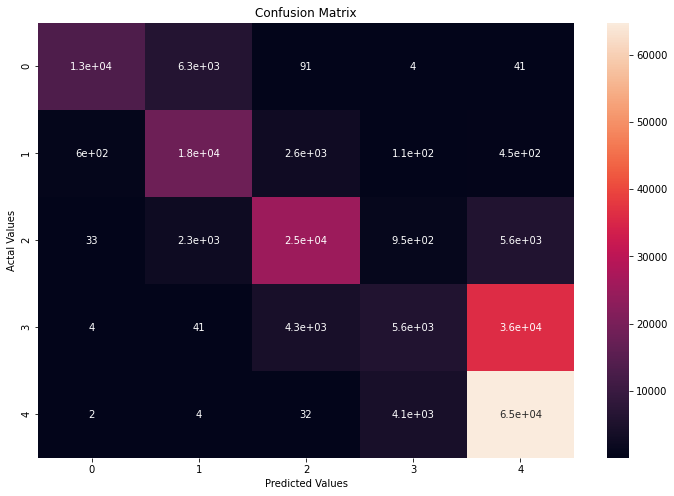

CPU times: user 6min 46s, sys: 17 s, total: 7min 3s
Wall time: 4min 20s


In [15]:
%%time  
# instantiating first model (most of these are defaults) ALTERING parameter in LogReg C, default=1.0
model = LogisticRegression(multi_class='multinomial',C=0.3, solver='lbfgs',max_iter=8_000,random_state=42)

model.fit(Xs_train, y_train)
preds_N_cm(model,Xs_train,y_train,Xs_test,y_test)

In [37]:
# creating dataframe for analysis of coefficients below 
coefs= model.coef_[0]
importances = X_train.columns


impotance_df = pd.DataFrame({'Coefficients': coefs, 'Word': importances})
impotance_df.sort_values(by='Coefficients',ascending=True).head()

,Coefficients,Word
1,-0.589180,vdcmun_id
2,-0.553143,ward_id
8,-0.358668,has_superstructure_mud_mortar_stone
20,-0.164994,has_secondary_use_agriculture
3,-0.129647,count_floors_pre_eq


In [38]:
impotance_df.sort_values(by='Coefficients',ascending=False).head()

,Coefficients,Word
0,1.051430,district_id
36,0.197360,roof_type_bamboo_timber_light_roof
37,0.189377,roof_type_rcc_rb_rbc
19,0.175384,has_secondary_use
40,0.132270,ground_floor_type_rc
